In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
# import pymongo
# import itertools
# from concurrent.futures import ProcessPoolExecutor
# from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import neighbors
# from sklearn.externals import joblib
from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX']:
#     if symbol == 'WDAY':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

# symbol = 'TSLA'

stock_df_dict = {}

for symbol in NASDAQ100:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close', 'volume']]
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 处理Coinmarketcap的早期缺失数据
    if symbol in CRYPTOCURRENCY:
        stock_df = stock_df.replace(to_replace='-', value=pd.np.nan)

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期，和news_df['publish_time']一致
    stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    stock_df.set_index(['date'], inplace=True)
    stock_df = stock_df.sort_index(axis=0, ascending=True)

    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df


Wall time: 4min 19s


In [4]:
show_df = None
show_df = stock_df_dict['NDX'].copy()

In [5]:
%%time

### BT

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-06-02'
# start_date = '2017-01-03'
end_date = '2018-05-01'

yesterday = None

show_df['CASH'] = pd.np.nan
show_df['PROPERTY'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    for order in hold:
        
        is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s win SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif stock_df_dict[order[1]].loc[today, 'close'] / order[4] < 0.75:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s loss SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'LOSS',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif today - order[0] > 30:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s TIMEUP SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'TIMEUP',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in NASDAQ100:
        if today not in stock_df_dict[symbol].index:
            continue
        
        # buy drop wait rise back
        is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
        
        # turtle buy N days
#         N = 20
#         is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).min()).loc[today])
        
        if is_buy:
            if stock_df_dict[symbol].loc[yesterday, 'close'] < stock_df_dict[symbol].shift(7).loc[yesterday, 'close']:
                continue
            if CASH < 10000:
                continue
            buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
#             print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

# s = 0
# c = 0
# for symbol in NASDAQ100:
# # for symbol in ['TSLA', 'NVDA', 'BIDU', 'FB']:
#     s_p = stock_df_dict[symbol].loc['2017-01-03', 'close']
#     e_p = stock_df_dict[symbol].loc['2018-01-03', 'close']
#     print(symbol, s_p, e_p, e_p / s_p)
#     s += e_p / s_p
#     c += 1

# print(s / c)

s_p = stock_df_dict['NDX'].loc[start_date, 'close']
e_p = stock_df_dict['NDX'].loc[end_date, 'close']
print('NDX', s_p, e_p, e_p / s_p)


89019.6853
[[Period('2018-04-18', 'D'), 'AMAT', 492, 54.729999999999997, 57.859999999999999], [Period('2018-04-19', 'D'), 'ALGN', 106, 252.78, 277.05000000000001], [Period('2018-04-19', 'D'), 'AMAT', 472, 51.189999999999998, 54.729999999999997], [Period('2018-04-19', 'D'), 'ASML', 111, 195.09999999999999, 206.31999999999999], [Period('2018-04-19', 'D'), 'KLAC', 191, 102.29000000000001, 108.23999999999999], [Period('2018-04-19', 'D'), 'LRCX', 92, 190.38999999999999, 203.77000000000001], [Period('2018-04-19', 'D'), 'SWKS', 169, 93.879999999999995, 98.959999999999994], [Period('2018-04-24', 'D'), 'PCAR', 286, 64.920000000000002, 69.409999999999997], [Period('2018-04-24', 'D'), 'QRTEA', 707, 23.640000000000001, 25.219999999999999], [Period('2018-04-25', 'D'), 'CHKP', 156, 96.329999999999998, 102.91], [Period('2018-04-26', 'D'), 'EBAY', 350, 38.68, 40.969999999999999], [Period('2018-04-27', 'D'), 'LBTYA', 400, 30.510000000000002, 32.490000000000002], [Period('2018-04-27', 'D'), 'LBTYK', 376

In [6]:
%%time
# %%lprun

### Turtle
TURTLE_POS = 10

HAPPY_MONEY = 0
PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

# start_date = '2008-06-02'
start_date = '2017-01-03'
end_date = '2018-05-01'
count_day = 0

yesterday = None

# show_df = None
# show_df = stock_df_dict['NDX'].copy()
show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

        
#     if PROPERTY > 100000 * 2:
#         hold = []
#         HAPPY_MONEY += 50000
#         PROPERTY -= 50000
#         CASH = PROPERTY
        

    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        
#         is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        N = 10
        is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == (stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min()).loc[today])
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 售出 SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
                  % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close'], CASH, PROPERTY))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in NASDAQ100:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        # buy drop wait rise back
#         is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
        
        # turtle buy N days
        N = 20
        if count_day < 20:
            is_buy = False
        else:
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[today])
#             is_buy = (stock_df_dict[symbol].loc[yesterday, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[yesterday])
        
        if is_buy:
#             if stock_df_dict[symbol].loc[yesterday, 'close'] < stock_df_dict[symbol].shift(7).loc[yesterday, 'close']:
#                 continue
            if CASH < PROPERTY / TURTLE_POS:
                continue
            buy = int(CASH / TURTLE_POS / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(CASH / TURTLE_POS / stock_df_dict[symbol].loc[today, 'open'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#             CASH -= stock_df_dict[symbol].loc[today, 'open'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0])
            print('%s 进场 BUY  %s * %d @ %f CASH=%d PROPERTY=%d' % 
                  (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], CASH, PROPERTY))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([stock_df_dict[order[1]].loc[yesterday, 'close'] * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

# s = 0
# c = 0
# for symbol in NASDAQ100:
# # for symbol in ['TSLA', 'NVDA', 'BIDU', 'FB']:
#     s_p = stock_df_dict[symbol].loc['2017-01-03', 'close']
#     e_p = stock_df_dict[symbol].loc['2018-01-03', 'close']
#     print(symbol, s_p, e_p, e_p / s_p)
#     s += e_p / s_p
#     c += 1

# print(s / c)

s_p = stock_df_dict['NDX'].loc[start_date, 'close']
e_p = stock_df_dict['NDX'].loc[end_date, 'close']
print('NDX', s_p, e_p, e_p / s_p)


2017-01-23 进场 BUY  ADBE * 90 @ 110.970000 CASH=90012 PROPERTY=100000
2017-01-23 进场 BUY  GOOGL * 10 @ 844.430000 CASH=81568 PROPERTY=100000
2017-01-23 进场 BUY  GOOG * 9 @ 819.310000 CASH=74194 PROPERTY=100000
2017-01-23 进场 BUY  AMZN * 9 @ 817.880000 CASH=66833 PROPERTY=100000
2017-01-23 进场 BUY  AAPL * 55 @ 120.080000 CASH=60229 PROPERTY=100000
2017-01-23 进场 BUY  BKNG * 3 @ 1554.990000 CASH=55564 PROPERTY=100000
2017-01-23 进场 BUY  CHTR * 17 @ 308.700000 CASH=50316 PROPERTY=100000
2017-01-23 进场 BUY  CHKP * 51 @ 97.790000 CASH=45329 PROPERTY=100000
2017-01-23 进场 BUY  CSX * 98 @ 45.990000 CASH=40822 PROPERTY=100000
2017-01-23 进场 BUY  EXPE * 34 @ 119.990000 CASH=36742 PROPERTY=100000
2017-01-23 进场 BUY  FB * 28 @ 128.930000 CASH=33132 PROPERTY=100000
2017-01-23 进场 BUY  INTU * 28 @ 117.100000 CASH=29853 PROPERTY=100000
2017-01-23 进场 BUY  JD * 105 @ 28.180000 CASH=26894 PROPERTY=100000
2017-01-23 进场 BUY  KLAC * 32 @ 82.100000 CASH=24267 PROPERTY=100000
2017-01-23 进场 BUY  LRCX * 21 @ 112.770000 C

2017-03-09 售出 SELL CTRP * 24 @ 47.170000 CASH=12569 PROPERTY=105689
2017-03-09 进场 BUY  ATVI * 25 @ 49.020000 CASH=11344 PROPERTY=105689
2017-03-09 进场 BUY  ALGN * 10 @ 105.360000 CASH=10290 PROPERTY=105689
2017-03-16 售出 SELL BIIB * 4 @ 278.960000 CASH=11406 PROPERTY=107746
2017-03-16 售出 SELL BIIB * 3 @ 278.960000 CASH=12243 PROPERTY=107746
2017-03-16 进场 BUY  ADBE * 10 @ 122.350000 CASH=11019 PROPERTY=107746
2017-03-16 进场 BUY  ALGN * 9 @ 110.470000 CASH=10025 PROPERTY=107746
2017-03-17 售出 SELL AMGN * 8 @ 168.610000 CASH=11374 PROPERTY=107452
2017-03-17 售出 SELL AMGN * 8 @ 168.610000 CASH=12723 PROPERTY=107452
2017-03-17 售出 SELL AMGN * 9 @ 168.610000 CASH=14240 PROPERTY=107452
2017-03-17 售出 SELL AMGN * 8 @ 168.610000 CASH=15589 PROPERTY=107452
2017-03-17 售出 SELL AMGN * 6 @ 168.610000 CASH=16601 PROPERTY=107452
2017-03-17 售出 SELL AMGN * 6 @ 168.610000 CASH=17612 PROPERTY=107452
2017-03-17 进场 BUY  ADBE * 13 @ 127.010000 CASH=15961 PROPERTY=107452
2017-03-17 进场 BUY  ALGN * 14 @ 111.850000 CAS

2017-04-13 售出 SELL ALGN * 14 @ 113.730000 CASH=35740 PROPERTY=108184
2017-04-13 售出 SELL WYNN * 23 @ 113.470000 CASH=38350 PROPERTY=108184
2017-04-13 售出 SELL WYNN * 9 @ 113.470000 CASH=39371 PROPERTY=108184
2017-04-13 售出 SELL AMZN * 2 @ 884.670000 CASH=41140 PROPERTY=108184
2017-04-13 售出 SELL CERN * 26 @ 58.610000 CASH=42664 PROPERTY=108184
2017-04-13 售出 SELL CMCSA * 33 @ 37.140000 CASH=43890 PROPERTY=108184
2017-04-13 售出 SELL DISH * 58 @ 62.380000 CASH=47508 PROPERTY=108184
2017-04-13 进场 BUY  EBAY * 138 @ 34.330000 CASH=42770 PROPERTY=108184
2017-04-17 进场 BUY  AAL * 96 @ 44.230000 CASH=38524 PROPERTY=107693
2017-04-17 进场 BUY  BMRN * 42 @ 90.700000 CASH=34715 PROPERTY=107693
2017-04-17 进场 BUY  EBAY * 100 @ 34.440000 CASH=31271 PROPERTY=107693
2017-04-17 进场 BUY  EXPE * 23 @ 130.340000 CASH=28273 PROPERTY=107693
2017-04-17 进场 BUY  ISRG * 11 @ 256.093300 CASH=25456 PROPERTY=107693
2017-04-17 进场 BUY  JD * 77 @ 32.720000 CASH=22936 PROPERTY=107693
2017-04-17 进场 BUY  MELI * 10 @ 220.480000 CA

2017-05-17 售出 SELL ADBE * 10 @ 134.330000 CASH=41618 PROPERTY=115540
2017-05-17 售出 SELL ADBE * 10 @ 134.330000 CASH=42961 PROPERTY=115540
2017-05-17 进场 BUY  VOD * 148 @ 28.840000 CASH=38693 PROPERTY=115540
2017-05-18 售出 SELL MELI * 10 @ 270.810000 CASH=41401 PROPERTY=112396
2017-05-18 进场 BUY  INCY * 32 @ 128.800000 CASH=37279 PROPERTY=112396
2017-05-18 进场 BUY  ISRG * 13 @ 286.660000 CASH=33553 PROPERTY=112396
2017-05-18 进场 BUY  QCOM * 59 @ 56.120000 CASH=30242 PROPERTY=112396
2017-05-18 进场 BUY  REGN * 6 @ 457.330000 CASH=27498 PROPERTY=112396
2017-05-18 进场 BUY  SHPG * 14 @ 190.000000 CASH=24838 PROPERTY=112396
2017-05-18 进场 BUY  VOD * 85 @ 29.010000 CASH=22372 PROPERTY=112396
2017-05-18 进场 BUY  XLNX * 34 @ 65.610000 CASH=20141 PROPERTY=112396
2017-05-19 进场 BUY  ADI * 24 @ 81.240000 CASH=18191 PROPERTY=113060
2017-05-19 进场 BUY  ADSK * 16 @ 109.910000 CASH=16433 PROPERTY=113060
2017-05-19 进场 BUY  CTSH * 25 @ 65.420000 CASH=14797 PROPERTY=113060
2017-05-19 进场 BUY  INCY * 11 @ 131.430000 C

2017-06-15 售出 SELL GOOGL * 1 @ 960.180000 CASH=12353 PROPERTY=113645
2017-06-15 售出 SELL AMZN * 1 @ 964.170000 CASH=13317 PROPERTY=113645
2017-06-15 售出 SELL AAL * 24 @ 49.110000 CASH=14496 PROPERTY=113645
2017-06-15 售出 SELL REGN * 6 @ 469.500000 CASH=17313 PROPERTY=113645
2017-06-15 售出 SELL GOOG * 1 @ 942.310000 CASH=18255 PROPERTY=113645
2017-06-15 售出 SELL AAL * 29 @ 49.110000 CASH=19680 PROPERTY=113645
2017-06-15 进场 BUY  MNST * 38 @ 51.300000 CASH=17730 PROPERTY=113645
2017-06-15 进场 BUY  PCAR * 27 @ 65.110000 CASH=15972 PROPERTY=113645
2017-06-15 进场 BUY  PAYX * 26 @ 60.730000 CASH=14393 PROPERTY=113645
2017-06-15 进场 BUY  QRTEA * 59 @ 24.360000 CASH=12956 PROPERTY=113645
2017-06-15 进场 BUY  VRSK * 15 @ 83.250000 CASH=11707 PROPERTY=113645
2017-06-16 售出 SELL AAL * 27 @ 48.790000 CASH=13025 PROPERTY=113579
2017-06-16 售出 SELL AAL * 25 @ 48.790000 CASH=14244 PROPERTY=113579
2017-06-16 售出 SELL BIIB * 20 @ 251.740000 CASH=19279 PROPERTY=113579
2017-06-16 售出 SELL BIIB * 16 @ 251.740000 CASH=23

2017-07-26 售出 SELL GOOGL * 1 @ 965.310000 CASH=11804 PROPERTY=116873
2017-07-26 进场 BUY  ATVI * 18 @ 62.640000 CASH=10676 PROPERTY=116873
2017-07-27 售出 SELL AMGN * 8 @ 172.150000 CASH=12053 PROPERTY=116860
2017-07-27 售出 SELL AMGN * 29 @ 172.150000 CASH=17046 PROPERTY=116860
2017-07-27 售出 SELL AMGN * 10 @ 172.150000 CASH=18767 PROPERTY=116860
2017-07-27 售出 SELL CELG * 18 @ 134.150000 CASH=21182 PROPERTY=116860
2017-07-27 售出 SELL AMGN * 12 @ 172.150000 CASH=23248 PROPERTY=116860
2017-07-27 售出 SELL CELG * 12 @ 134.150000 CASH=24857 PROPERTY=116860
2017-07-27 售出 SELL AMGN * 7 @ 172.150000 CASH=26062 PROPERTY=116860
2017-07-27 售出 SELL AMGN * 7 @ 172.150000 CASH=27268 PROPERTY=116860
2017-07-27 售出 SELL CELG * 9 @ 134.150000 CASH=28475 PROPERTY=116860
2017-07-27 售出 SELL JBHT * 17 @ 90.850000 CASH=30019 PROPERTY=116860
2017-07-27 售出 SELL JBHT * 17 @ 90.850000 CASH=31564 PROPERTY=116860
2017-07-27 售出 SELL AMGN * 15 @ 172.150000 CASH=34146 PROPERTY=116860
2017-07-27 售出 SELL PCAR * 25 @ 68.160000 

2017-08-18 进场 BUY  ROST * 75 @ 59.020000 CASH=39960 PROPERTY=114445
2017-08-18 进场 BUY  TTWO * 43 @ 92.070000 CASH=36001 PROPERTY=114445
2017-08-21 售出 SELL ALGN * 9 @ 167.980000 CASH=37513 PROPERTY=114215
2017-08-21 售出 SELL ALGN * 9 @ 167.980000 CASH=39025 PROPERTY=114215
2017-08-21 售出 SELL ALGN * 11 @ 167.980000 CASH=40872 PROPERTY=114215
2017-08-21 售出 SELL CTSH * 21 @ 69.520000 CASH=42332 PROPERTY=114215
2017-08-21 售出 SELL CTSH * 36 @ 69.520000 CASH=44835 PROPERTY=114215
2017-08-21 进场 BUY  MNST * 82 @ 54.360000 CASH=40377 PROPERTY=114215
2017-08-22 进场 BUY  ATVI * 62 @ 64.260000 CASH=36393 PROPERTY=114360
2017-08-22 进场 BUY  ADBE * 23 @ 152.250000 CASH=32892 PROPERTY=114360
2017-08-22 进场 BUY  CERN * 50 @ 65.370000 CASH=29623 PROPERTY=114360
2017-08-22 进场 BUY  CHKP * 27 @ 108.910000 CASH=26683 PROPERTY=114360
2017-08-22 进场 BUY  ISRG * 8 @ 332.200000 CASH=24025 PROPERTY=114360
2017-08-22 进场 BUY  JBHT * 24 @ 97.900000 CASH=21675 PROPERTY=114360
2017-08-22 进场 BUY  MNST * 39 @ 55.380000 CASH

2017-09-27 售出 SELL BIIB * 4 @ 312.800000 CASH=12073 PROPERTY=118484
2017-09-27 进场 BUY  GOOGL * 1 @ 959.900000 CASH=11113 PROPERTY=118484
2017-09-28 售出 SELL ALGN * 16 @ 183.040000 CASH=14042 PROPERTY=119365
2017-09-28 售出 SELL ALGN * 10 @ 183.040000 CASH=15872 PROPERTY=119365
2017-09-28 售出 SELL ALGN * 17 @ 183.040000 CASH=18984 PROPERTY=119365
2017-09-28 进场 BUY  GOOGL * 1 @ 964.810000 CASH=18019 PROPERTY=119365
2017-09-28 进场 BUY  GOOG * 1 @ 949.500000 CASH=17070 PROPERTY=119365
2017-09-28 进场 BUY  ADI * 19 @ 85.640000 CASH=15442 PROPERTY=119365
2017-09-28 进场 BUY  AMAT * 30 @ 50.620000 CASH=13924 PROPERTY=119365
2017-09-28 进场 BUY  ASML * 8 @ 170.490000 CASH=12560 PROPERTY=119365
2017-09-28 进场 BUY  BIDU * 5 @ 241.280000 CASH=11353 PROPERTY=119365
2017-10-02 售出 SELL XRAY * 20 @ 56.330000 CASH=12480 PROPERTY=120337
2017-10-02 进场 BUY  AAL * 26 @ 47.730000 CASH=11239 PROPERTY=120337
2017-10-03 售出 SELL CSX * 42 @ 52.120000 CASH=13428 PROPERTY=119960
2017-10-03 售出 SELL CSX * 40 @ 52.120000 CASH=1

2017-10-26 进场 BUY  INTU * 8 @ 151.330000 CASH=11932 PROPERTY=121420
2017-10-27 售出 SELL AAL * 39 @ 47.560000 CASH=13787 PROPERTY=122030
2017-10-27 进场 BUY  ATVI * 21 @ 64.140000 CASH=12440 PROPERTY=122030
2017-10-27 进场 BUY  ADBE * 7 @ 177.330000 CASH=11199 PROPERTY=122030
2017-10-31 售出 SELL DLTR * 41 @ 91.250000 CASH=14940 PROPERTY=123569
2017-10-31 售出 SELL DLTR * 18 @ 91.250000 CASH=16582 PROPERTY=123569
2017-10-31 售出 SELL DLTR * 30 @ 91.250000 CASH=19320 PROPERTY=123569
2017-10-31 售出 SELL DLTR * 16 @ 91.250000 CASH=20780 PROPERTY=123569
2017-10-31 售出 SELL MYL * 46 @ 35.710000 CASH=22422 PROPERTY=123569
2017-10-31 售出 SELL DLTR * 17 @ 91.250000 CASH=23974 PROPERTY=123569
2017-10-31 进场 BUY  ATVI * 36 @ 65.490000 CASH=21616 PROPERTY=123569
2017-10-31 进场 BUY  ALGN * 9 @ 238.980000 CASH=19465 PROPERTY=123569
2017-10-31 进场 BUY  AAPL * 11 @ 169.040000 CASH=17606 PROPERTY=123569
2017-10-31 进场 BUY  ASML * 9 @ 180.750000 CASH=15979 PROPERTY=123569
2017-10-31 进场 BUY  ADSK * 12 @ 124.960000 CASH=14

2017-11-29 进场 BUY  CTAS * 18 @ 153.730000 CASH=25858 PROPERTY=127986
2017-11-29 进场 BUY  COST * 14 @ 177.530000 CASH=23373 PROPERTY=127986
2017-11-29 进场 BUY  CSX * 42 @ 54.440000 CASH=21087 PROPERTY=127986
2017-11-29 进场 BUY  DISH * 41 @ 51.280000 CASH=18984 PROPERTY=127986
2017-11-29 进场 BUY  DLTR * 18 @ 104.140000 CASH=17110 PROPERTY=127986
2017-11-29 进场 BUY  ESRX * 27 @ 62.860000 CASH=15412 PROPERTY=127986
2017-11-29 进场 BUY  FAST * 30 @ 51.240000 CASH=13875 PROPERTY=127986
2017-11-29 进场 BUY  HOLX * 32 @ 42.270000 CASH=12523 PROPERTY=127986
2017-11-30 售出 SELL AMAT * 38 @ 52.770000 CASH=14528 PROPERTY=124561
2017-11-30 进场 BUY  AAL * 28 @ 50.490000 CASH=13114 PROPERTY=124561
2017-11-30 进场 BUY  AMGN * 7 @ 175.660000 CASH=11884 PROPERTY=124561
2017-12-01 售出 SELL ADSK * 15 @ 107.060000 CASH=13490 PROPERTY=125635
2017-12-01 售出 SELL XRAY * 45 @ 66.080000 CASH=16464 PROPERTY=125635
2017-12-01 售出 SELL XRAY * 20 @ 66.080000 CASH=17786 PROPERTY=125635
2017-12-01 售出 SELL XRAY * 55 @ 66.080000 CASH=

2018-01-08 售出 SELL LBTYA * 40 @ 35.250000 CASH=13237 PROPERTY=126160
2018-01-08 售出 SELL LBTYA * 88 @ 35.250000 CASH=16339 PROPERTY=126160
2018-01-08 进场 BUY  ALGN * 6 @ 248.900000 CASH=14846 PROPERTY=126160
2018-01-08 进场 BUY  GOOGL * 1 @ 1114.210000 CASH=13732 PROPERTY=126160
2018-01-08 进场 BUY  GOOG * 1 @ 1106.940000 CASH=12625 PROPERTY=126160
2018-01-08 进场 BUY  AMZN * 1 @ 1246.870000 CASH=11378 PROPERTY=126160
2018-01-10 售出 SELL FAST * 35 @ 54.410000 CASH=13282 PROPERTY=126573
2018-01-10 售出 SELL VOD * 54 @ 31.650000 CASH=14991 PROPERTY=126573
2018-01-10 售出 SELL FAST * 30 @ 54.410000 CASH=16624 PROPERTY=126573
2018-01-10 进场 BUY  ATVI * 24 @ 66.830000 CASH=15020 PROPERTY=126573
2018-01-10 进场 BUY  ADBE * 8 @ 187.110000 CASH=13523 PROPERTY=126573
2018-01-10 进场 BUY  AMZN * 1 @ 1254.330000 CASH=12269 PROPERTY=126573
2018-01-11 售出 SELL VOD * 107 @ 31.440000 CASH=15633 PROPERTY=126290
2018-01-11 进场 BUY  ATVI * 22 @ 69.240000 CASH=14109 PROPERTY=126290
2018-01-11 进场 BUY  ADBE * 7 @ 188.920000 C

2018-02-06 售出 SELL CHTR * 4 @ 369.750000 CASH=67443 PROPERTY=124306
2018-02-06 售出 SELL CHTR * 4 @ 369.750000 CASH=68922 PROPERTY=124306
2018-02-06 售出 SELL CHTR * 7 @ 369.750000 CASH=71510 PROPERTY=124306
2018-02-06 售出 SELL IDXX * 9 @ 180.050000 CASH=73131 PROPERTY=124306
2018-02-06 售出 SELL CHTR * 11 @ 369.750000 CASH=77198 PROPERTY=124306
2018-02-06 进场 BUY  SWKS * 73 @ 104.560000 CASH=69565 PROPERTY=124306
2018-02-07 售出 SELL BIIB * 5 @ 326.890000 CASH=71200 PROPERTY=125204
2018-02-07 售出 SELL TTWO * 10 @ 117.190000 CASH=72371 PROPERTY=125204
2018-02-07 售出 SELL LBTYK * 97 @ 34.420000 CASH=75710 PROPERTY=125204
2018-02-07 进场 BUY  HAS * 74 @ 102.220000 CASH=68146 PROPERTY=125204
2018-02-08 售出 SELL AMZN * 1 @ 1350.500000 CASH=69496 PROPERTY=124496
2018-02-08 售出 SELL AMZN * 1 @ 1350.500000 CASH=70847 PROPERTY=124496
2018-02-08 售出 SELL MAR * 11 @ 133.880000 CASH=72320 PROPERTY=124496
2018-02-08 售出 SELL AMZN * 1 @ 1350.500000 CASH=73670 PROPERTY=124496
2018-02-08 售出 SELL AMZN * 1 @ 1350.500000

2018-03-23 售出 SELL ADBE * 31 @ 215.020000 CASH=75624 PROPERTY=127491
2018-03-23 售出 SELL MU * 63 @ 54.210000 CASH=79040 PROPERTY=127491
2018-03-23 售出 SELL INTU * 11 @ 169.870000 CASH=80908 PROPERTY=127491
2018-03-23 售出 SELL ADSK * 20 @ 128.020000 CASH=83469 PROPERTY=127491
2018-03-23 售出 SELL MU * 93 @ 54.210000 CASH=88510 PROPERTY=127491
2018-03-23 售出 SELL ADSK * 15 @ 128.020000 CASH=90430 PROPERTY=127491
2018-03-23 售出 SELL ASML * 10 @ 199.110000 CASH=92421 PROPERTY=127491
2018-03-23 售出 SELL ADBE * 10 @ 215.020000 CASH=94572 PROPERTY=127491
2018-03-23 售出 SELL IDXX * 7 @ 190.310000 CASH=95904 PROPERTY=127491
2018-03-23 售出 SELL ADBE * 15 @ 215.020000 CASH=99129 PROPERTY=127491
2018-03-23 售出 SELL MU * 46 @ 54.210000 CASH=101623 PROPERTY=127491
2018-03-26 进场 BUY  INTC * 193 @ 52.480000 CASH=91494 PROPERTY=125160
2018-03-27 售出 SELL ADBE * 12 @ 213.800000 CASH=94060 PROPERTY=125919
2018-03-27 售出 SELL MU * 39 @ 52.400000 CASH=96103 PROPERTY=125919
2018-03-27 售出 SELL EA * 12 @ 119.980000 CASH=9

In [7]:
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
    print(symbol, s_p, e_p, e_p / s_p)


NDX [ 4911.336] [ 6681.961] [ 1.36051799]
ATVI [ 36.64] [ 67.8] [ 1.85043668]
ADBE [ 103.48] [ 224.08] [ 2.1654426]
ALXN [ 122.63] [ 118.62] [ 0.96730001]
ALGN [ 96.96] [ 251.34] [ 2.59220297]
GOOGL [ 808.01] [ 1040.75] [ 1.28804099]
GOOG [ 786.14] [ 1037.31] [ 1.3194978]
AMZN [ 753.67] [ 1582.26] [ 2.0994069]
AAL [ 46.3] [ 43.36] [ 0.93650108]
AMGN [ 150.73] [ 169.28] [ 1.12306774]
ADI [ 72.505] [ 88.86] [ 1.22557065]
AAPL [ 116.15] [ 169.1] [ 1.45587602]
AMAT [ 31.94] [ 50.91] [ 1.59392611]
ASML [ 110.45] [ 191.44] [ 1.73327297]
ADSK [ 76.18] [ 127.06] [ 1.66789184]
ADP [ 103.5] [ 118.8] [ 1.14782609]
BIDU [ 168.3] [ 252.13] [ 1.49809863]
BIIB [ 273.1422] [ 274.61] [ 1.00537376]
BMRN [ 85.84] [ 86.16] [ 1.00372787]
BKNG [ 1477.57] [ 2179.39] [ 1.47498257]
AVGO [ 178.34] [ 230.38] [ 1.29180218]
CA [ 32.29] [ 34.97] [ 1.08299783]
CDNS [ 25.34] [ 40.34] [ 1.59194949]
CELG [ 118.75] [ 87.93] [ 0.74046316]
CERN [ 49.4] [ 58.81] [ 1.19048583]
CHTR [ 285.77] [ 279.4] [ 0.97770935]
CHKP [ 84

In [8]:
# pd.set_option('display.max_rows', 1000)
# recode_df
# recode_df.loc[recode_df['ops']=='SELL']

d:\python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
d:\python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
d:\python3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

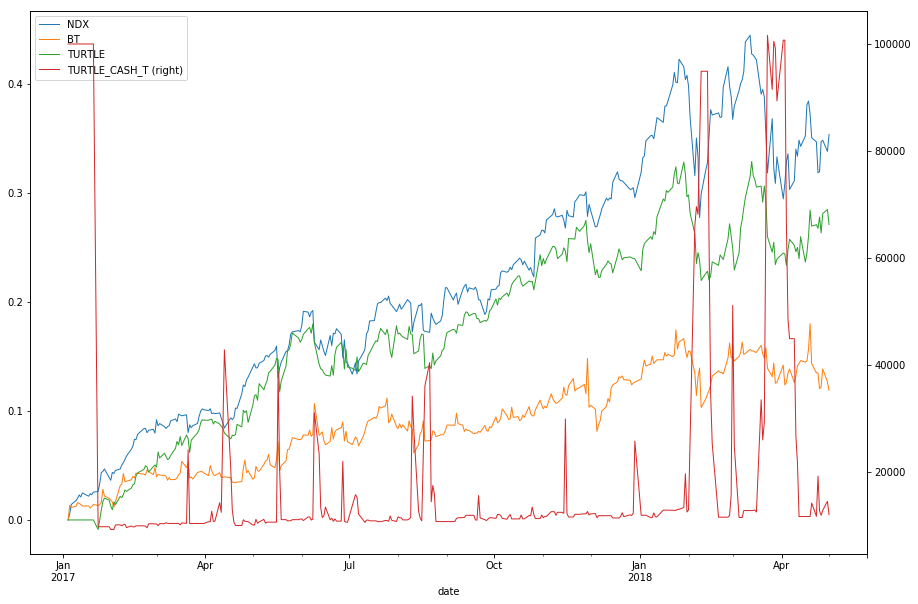

In [9]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False)
df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
df['PROPERTY'] = (df['PROPERTY'] - df.head(1)['PROPERTY'].values) / df.head(1)['PROPERTY'].values
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.head(1)['PROPERTY_T'].values) / df.head(1)['PROPERTY_T'].values
# df['CASH'] = df['CASH'] / df.head(1)['CASH'].values
# df['CASH_T'] = (df['CASH_T'] - df.head(1)['CASH_T'].values) / df.head(1)['PROPERTY_T'].values

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY', secondary_y=False, label='BT', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T', secondary_y=False, label='TURTLE', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='CASH_T', secondary_y=True, label='TURTLE_CASH_T', linewidth=1, ax=ax)O

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()